# Part 3: Two Groups and a Time to Event Outcome 
## David Schlueter
### April 25, 2017

### Introduction
We saw in the previous lecture how to perform Bayesian Analysis for Binary outcomes. This week, we will be discussing how to perform Bayesian inference for two groups with a time to event outcome.



### Time to event data

Often, in medical research we are interested in determining how a drug, therapy, or other intervention affects the longevity of a certain outcome. For example, a researcher may be interested in how a particular drug affects how long a person will survive with a particular disease. We have already seen how the Bayesian paradigm is able to accomodate the presence or abscence of a disease between two groups - however, we wish to go a step further and incorporate the temporal element of disease progression into the framework. 

As discussed in previous lectures, there are a few ingredients in the Bayesian framework:
    1. Likelihood 
    2. Prior Distributions
 
In survival analysis, the first component is somewhat more involved in its formulation. To be able to properly discuss the likelihood specification in Survival models, we must first discuss several key quantities in survival analysis. As discussed our main outcome of interest is time, which has support $0\leq t< \infty$. We denote our time as with a random variable $T$.

1. Survival Function

Since $T$ is a random variable, we can calculate probability statements associated with it. Specifically for survival analysis, we are often interested in the probability that the event occured after some specific time (e.g. S(t) = P(T > t)). 

For a weibull distributed random variable, the survival function is given by:
$$
\begin{eqnarray}
S(t)=\lambda t^{\alpha}
\end{eqnarray}
$$


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3 import Gamma, Poisson, Normal, Model, sample, forestplot, NUTS, Metropolis, find_MAP, starting, traceplot
import seaborn as sns
import matplotlib.pyplot as plt
import pdb


from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
from statsmodels import datasets
from theano import tensor as tt

sns.set_style("ticks")

rseed = 20090425, 19700903
np.random.seed(rseed)

In [60]:
df.shape

(44, 3)

In [2]:
df = datasets.get_rdataset('mastectomy', 'HSAUR', cache=True).data
df.event = df.event.astype(np.int64)
df.metastized = (df.metastized == 'yes').astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

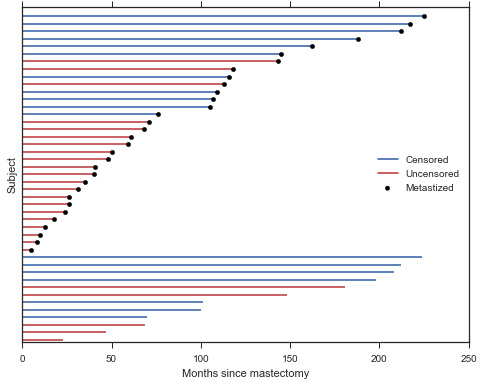

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

ax.hlines(patients[df.event.values == 0], 0, df[df.event.values == 0].time,
          color=blue, label='Censored')

ax.hlines(patients[df.event.values == 1], 0, df[df.event.values == 1].time,
          color=red, label='Uncensored')

ax.scatter(df[df.metastized.values == 1].time, patients[df.metastized.values == 1],
           color='k', zorder=10, label='Metastized')

ax.set_xlim(left=0)
ax.set_xlabel('Months since mastectomy')
ax.set_yticks([])
ax.set_ylabel('Subject')

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='center right');

In [4]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [5]:
kmf.fit(df.time, event_observed=df.event)


<lifelines.KaplanMeierFitter: fitted with 44 observations, 18 censored>

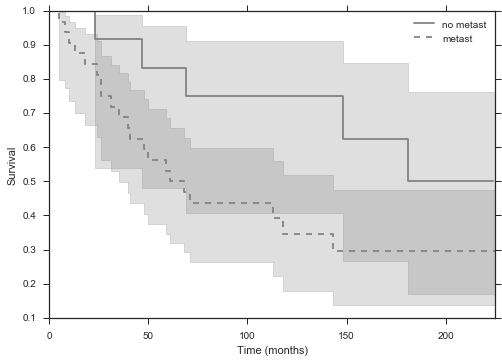

In [6]:
time = df.time
event = df.event
ix0 = df.metastized==0
ix1 = df.metastized==1

kmf.fit(time[ix0], event[ix0], label='no metast')
ax = kmf.plot(color='grey')

kmf.fit(time[ix1], event[ix1], label='metast')
kmf.plot(ax=ax, ls='dashed', color='grey')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival')

# Model Specification

We wish to relate a treatment effect in some way to the time to event outcome. There are several ways to do this, but two main paradigms are pervasive in the literature:
    1. Proportional Hazards 
    2. Accelerated Failure Time
In this lecture we will focus on the first. 

## Proportional Hazards Model

The main objective at this point is to specify a model that relates the group effect to time outcome. Recall above that the hazard quantifies the instantaneous risk of disease at a given time point

describing how the risk of event per time unit changes over time at baseline levels of covariates; and the effect parameters, describing how the hazard varies in response to explanatory covariates.

Let Yi denote the observed time (either censoring time or event time) for subject i. Let Ci be the indicator that the time corresponds to an event (i.e. if Ci = 1 the event occurred and if Ci = 0 the time is a censoring time). Let Xi = {Xi1, … Xip} be the realized values of the covariates for subject i. The hazard function for the Cox proportional hazard model has the form
$$
{\displaystyle \lambda (t|X_{i})=)=\lambda _{0}(t)\exp(X_{i}\cdot \beta ).}
$$

This expression gives the hazard rate at time t for subject i with covariate vector (explanatory variables) Xi.




## Likelihood Specification

Due to right censoring, we need to adjust our likelihood to account for observations where we know that an individual survived up to a particular point. If a person is known to have survived at least to time T, then their likelihood contribution is simply the survival function evaluated at the censoring time. We typically express this with an indicator function for each observation denoting whether or not the individual was right censored or observed.

First, recall that the Weibull proportional hazards model models the hazard as a function of the covariates. The probability density function is related to the hazard by:

$$
\begin{equation}
f(t) = h(t)S(t)
\end{equation}
$$


The likelihood specification for an individual is therefore given by:
$$
\begin{eqnarray}
L &=& [f(t|X)]^{\delta_i}[S(t|X)]^{1-\delta_i}\\
&=& [h(t|X)S(t|X)]^{\delta_i}[S(t|X)]^{1-\delta_i}\\
&=& [\alpha\lambda t^{\alpha-1}\exp(\beta^T X)exp(-\lambda t^{\alpha}\exp(\beta^T X))]^{\delta_i}[exp(-\lambda t^{\alpha}\exp(\beta^T X))]^{1-\delta_i}\\
\end{eqnarray}
$$



In [7]:
metast = df.metastized

In [98]:
n_iterations = 5000
n_burn = 1000

In [77]:
# Benchmark with mcmc sampler

with Model() as weibull_model:
    l = pm.Gamma('l', 1,1)
    # Weibull shape parameter
    k = pm.HalfCauchy("k", 2.5)
    # Effects of morcellation and power
    β = pm.Normal('β', np.zeros(2), np.ones(2)*100, shape=2)
    
    # Weibull scales
    λ = pm.Deterministic('λ', tt.exp(β[0]+β[1]*np.array(metast)))

    # Weibull survival likelihood, accounting for censoring
    def logp(event):
        return event*(tt.log(l)+tt.log(k) + tt.log(λ) + (k-1)*tt.log(np.array(time))) - (l*λ * np.array(time)**k)

    survival = pm.DensityDist('survival', logp, observed={'event':event})
    weibull_trace = pm.sample(5000)

100%|█████████▉| 4988/5000 [00:25<00:00, 218.40it/s]/Users/schluetd/Desktop/pymc3/pymc3/step_methods/hmc/nuts.py:237: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 5000/5000 [00:26<00:00, 192.12it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15887d898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x158395588>]], dtype=object)

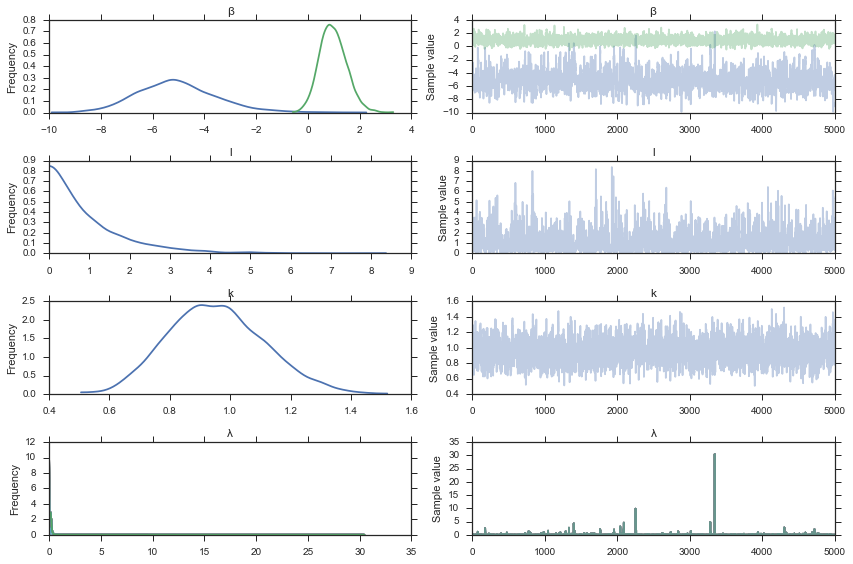

In [78]:
pm.traceplot(weibull_trace) 

In [89]:
hr_samps = np.exp(weibull_trace['β'][1000:,1])
print('Hazard ratio (metastisized vs not metastisized) at 5 years: {0} {1}'.format(hr_samps.mean(), 
                                                                     np.percentile(hr_samps, [2.5, 97.5])))

Hazard ratio (metastisized vs not metastisized) at 5 years: 3.026102049010212 [ 1.05339203  7.65155219]


In [90]:
## Plot survival curves 
n_intervals = 120
interval_bounds = np.arange(0, n_intervals + 1, 1)

In [91]:
baseline_lam = np.exp(weibull_trace['β'][n_burn:,0])
metast_lam = np.exp(weibull_trace['β'][n_burn:,0] + weibull_trace['β'][n_burn:, 1])
k_trace = weibull_trace['k'][n_burn:]
l_trace = weibull_trace['l'][n_burn:]



In [92]:
def plot_with_hpd(x, lam, f, ax, linestyle='-', color=None, label=None, alpha=0.05, debug=False, **kwargs):

    m = np.median(f(lam, **kwargs), axis=0)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(lam, **kwargs), percentiles, axis=0)
    
    if debug:
        import pdb;pdb.set_trace()
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, m, color=color, linestyle=linestyle, label=label);

In [93]:
def cum_weibull_hazard(lam, l=l_trace ,k=k_trace, t=n_intervals):
    return (l_trace.reshape(-1,1)*lam.reshape(-1,1) * np.arange(t)) ** k.reshape(-1,1)

def weibull_survival(lam,l=l_trace, k=k_trace, t=n_intervals):
    return np.exp(-cum_weibull_hazard(lam,l, k, t))


def cum_hazard(hazard, n=n_intervals):
    return (np.arange(n) * hazard.reshape(-1,1)).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

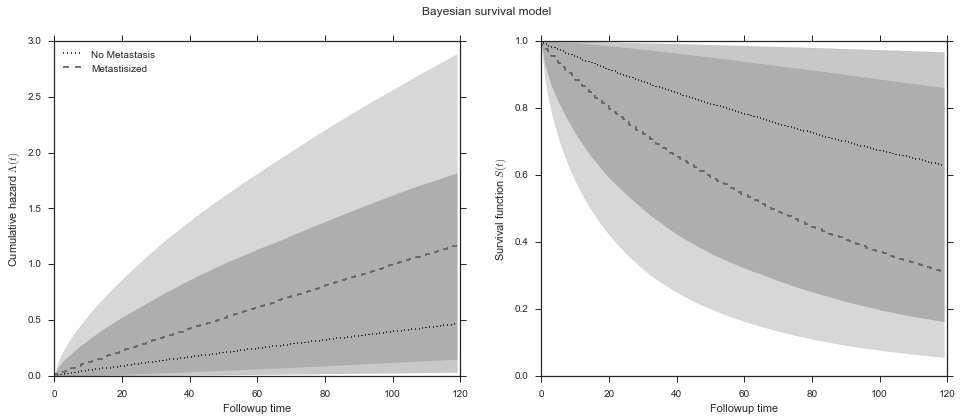

In [94]:
greys = ['#969696', '#636363', '#252525']
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_lam, cum_weibull_hazard,
              hazard_ax, color=greys[2], linestyle=':', label='No Metastasis')
plot_with_hpd(interval_bounds[:-1], metast_lam, cum_weibull_hazard,
              hazard_ax, color=greys[1], linestyle='--', label='Metastisized')

hazard_ax.set_xlim(0, n_intervals);
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_lam, weibull_survival,
              surv_ax, color=greys[2], linestyle=':')
plot_with_hpd(interval_bounds[:-1], metast_lam, weibull_survival,
              surv_ax, color=greys[1], linestyle='--')


surv_ax.set_xlim(0, n_intervals);
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

In [95]:
## Hazard ratio comparing 2 groups at a given time point 

def weibull_hazard(lam, t,l=l_trace, k=k_trace):
    return (l.reshape(-1,1) * k.reshape(-1,1) * lam.reshape(-1,1) * t**(k.reshape(-1,1) - 1))

In [96]:
hazard_ratio = weibull_hazard(metast_lam, 60)/weibull_hazard(baseline_lam, 60)
print('Hazard ratio (metastisized vs notmetastisized) at 5 years: {0} {1}'.format(hazard_ratio.mean(), 
                                                                     np.percentile(hazard_ratio, [2.5, 97.5])))

Hazard ratio (metastisized vs notmetastisized) at 5 years: 3.026102049010212 [ 1.05339203  7.65155219]
